In [400]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# define matplotlib style
plt.style.use("classic")
mpl.rc("xtick", labelsize=23)
mpl.rc("ytick", labelsize=23)
mpl.rc("xtick.major", size=15, width=2)
mpl.rc("xtick.minor", size=8, width=2, visible=True)
mpl.rc("ytick.major", size=15, width=2)
mpl.rc("ytick.minor", size=8, width=2, visible=True)
mpl.rc("lines", linewidth=3, markersize=20)
mpl.rc("axes", linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc("legend", fontsize=25, loc="best", frameon=False, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [401]:
import numpy as np

In [402]:
from tidaldisruptionlrd import diffusion_coeff, eddington_inversion, tdr_rate
from tidaldisruptionlrd.constants import G

In [403]:
import importlib

importlib.reload(diffusion_coeff)
importlib.reload(eddington_inversion)
importlib.reload(tdr_rate)

<module 'tidaldisruptionlrd.tdr_rate' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/tdr_rate.py'>

In [ ]:
class IsothermalSphereProfile(eddington_inversion.BaseProfile):
    def __init__(
        self,
        M_bh=1,
        sigma=1,
        r_bin_min_scaler=1e-5,
        r_bin_max_scaler=1e5,
        N_bins=10000,
    ):
        self.sigma = sigma or self._get_sigma(M_bh)
        _dimensionless = M_bh == 1 and sigma == 1
        self.r_h = 1 if _dimensionless else G * M_bh / self.sigma**2
        super().__init__(
            r_bin_min=r_bin_min_scaler * self.r_h,
            r_bin_max=r_bin_max_scaler * self.r_h,
            N_bins=N_bins,
            M_bh=M_bh,
            G=1 if _dimensionless else G,
            r_zero_phi=self.r_h,
        )

    def _get_sigma(self, M_bh):
        return 200 * (M_bh / 1.48e8) ** (1 / 4.65)

    def _get_stellar_rho_bins(self, r_bins):
        return self.M_bh / (2 * np.pi * self.r_h * r_bins**2)

In [405]:
isothermal_sphere = IsothermalSphereProfile(M_bh=1, sigma=1)

Eddington's inversion: 100%|██████████| 9999/9999 [00:12<00:00, 817.68it/s] 


/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/eddington_inversion.py:224: RuntimeWarning: divide by zero encountered in log
  return 4 * np.pi * v**2 * np.exp(_lin_log_eddington_interp(psi - v**2 / 2))
Reconstructing densities: 100%|██████████| 10000/10000 [00:03<00:00, 2590.40it/s]


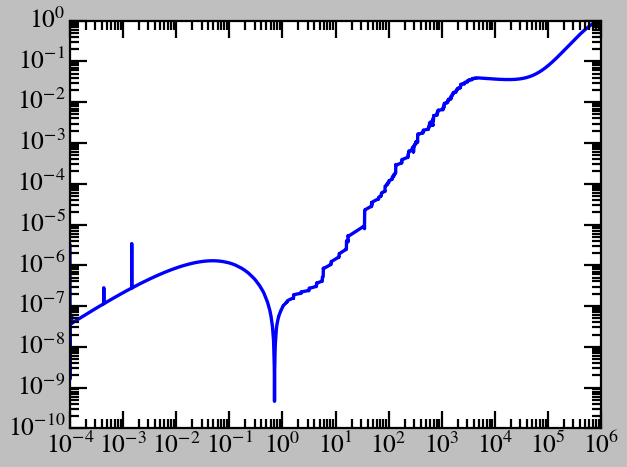

In [406]:
reconstructed_stellar_rho_bins = isothermal_sphere.reconstruct_stellar_rho_bins()

plt.plot(
    isothermal_sphere.r_bins,
    np.abs(1 - reconstructed_stellar_rho_bins / isothermal_sphere.stellar_rho_bins),
)

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

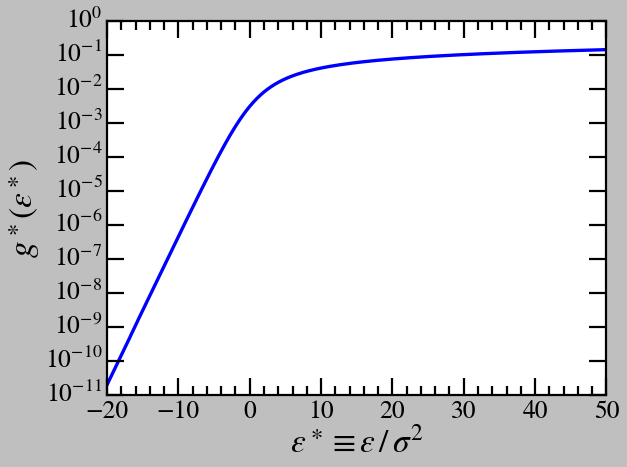

In [407]:
plt.plot(
    isothermal_sphere.eta_bins,
    isothermal_sphere.f_eta_bins,
)

# plt.xscale("log")
plt.yscale("log")

plt.xlim(-20, 50)
plt.ylim(1e-11, 1e0)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$g^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

In [408]:
isothermal_diffusion_coeff = diffusion_coeff.DiffusionCoefficient(
    r_bins=isothermal_sphere.r_bins,
    stellar_mass_bins=isothermal_sphere.stellar_mass_bins,
    M_bh=isothermal_sphere.M_bh,
    phi_bins=isothermal_sphere.phi_bins,
    eta_bins=isothermal_sphere.eta_bins,
    f_eta_bins=isothermal_sphere.f_eta_bins,
    reduce_factor=10,
    G=1,
)

/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/diffusion_coeff.py:135: RuntimeWarning: divide by zero encountered in log
  return get_interp(self.eta_bins, np.log(self.f_eta_bins))
Computing diffusion coefficients:  82%|████████▏ | 822/1000 [00:42<00:03, 51.59it/s]/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/diffusion_coeff.py:196: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  * quad(
Computing diffusion coefficients: 100%|██████████| 1000/1000 [00:44<00:00, 22.47it/s]


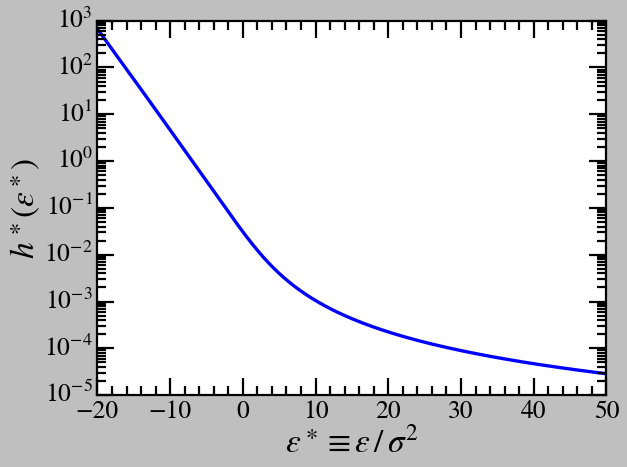

In [409]:
plt.plot(
    isothermal_diffusion_coeff.eta_bins,
    isothermal_diffusion_coeff.scaled_diff_coeff_bins
    * isothermal_diffusion_coeff.Jc_sqr_bins,
)

# plt.xscale("log")
plt.yscale("log")

plt.xlim(-20, 50)
plt.ylim(1e-5, 1e3)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$h^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

In [410]:
importlib.reload(tdr_rate)

<module 'tidaldisruptionlrd.tdr_rate' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/tdr_rate.py'>

In [411]:
tdr = tdr_rate.TDRRate(
    eta_ast_bins=isothermal_diffusion_coeff.eta_bins,
    g_ast_bins=isothermal_diffusion_coeff.f_eta_bins,
    h_ast_bins=isothermal_diffusion_coeff.scaled_diff_coeff_bins
    * isothermal_diffusion_coeff.Jc_sqr_bins,
    Jc_sqr_ast_bins=isothermal_diffusion_coeff.Jc_sqr_bins,
    M_bh=np.logspace(4, 8, 1000),
    sigma=100,
    m_s=1,
    r_s=1,
)

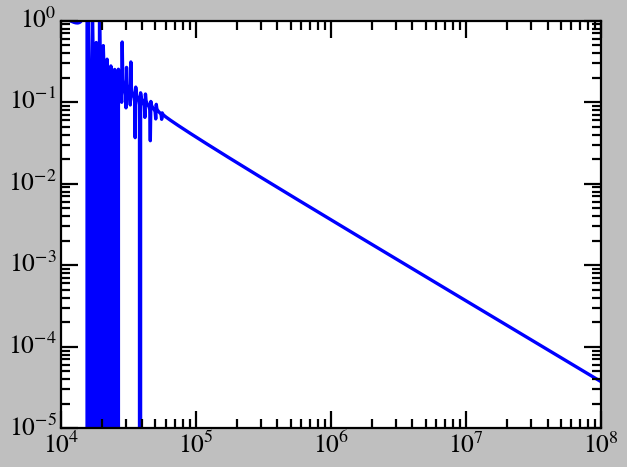

In [412]:
plt.plot(tdr.M_bh, tdr.N_rate)

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e4, 1e8)
plt.ylim(1e-5, 1e0)

plt.tight_layout()
plt.show()